In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



In [3]:
CSV_PATH = "/content/Datos_Imgenes.csv"
df = pd.read_csv(CSV_PATH)
#df = pd.read_csv(CSV_PATH)
df.head(3)

,Unnamed: 0,Date,Model,ClassId,Page,TotalPages,PagesProcessed,Fields,EmptyFields,ModelApplied,ModelReported,Details,ConfR,ConfA,ConfW,Sharpness,Contrast,Clarity,Resolution,DocType
0,0,2025-01-22T20:34:48-08:00,comprobante_domicilio,NaN,1,1,1,12.0,0.0,Lynx_ProofAddress_v6,NaN,CDOM-CFE[1|0.2],0.981,0.674,0.889,64.0,38.0,2523.0,263.0,CFE
1,1,2025-01-22T20:34:48-08:00,recibo_nomina,NaN,1,2,1,15.0,0.0,Lynx_ProofPaysheet_v5,NOM-IMSS[1|0.2],NOM-IMSS[1|0.2],0.948,0.931,0.943,399.0,42.0,17045.0,672.0,IMSS
2,2,2025-01-22T20:34:48-08:00,recibo_nomina,NaN,2,2,1,15.0,3.0,Lynx_ProofPaysheet_v5,NOM-IMSS[1|0.2],NOM-IMSS[1|0.2],0.941,0.837,0.910,166.0,29.0,4866.0,233.0,IMSS


In [4]:
# Make a copy of the DataFrame
df_transformed = df.copy()
#*Drop Unnecessary Columns**
df_transformed = df_transformed.drop(columns=['Unnamed: 0','Date','ClassId','Page','TotalPages','PagesProcessed','ModelApplied','ModelReported','Details'])

In [5]:
df_transformed.columns

Index(['Model', 'Fields', 'EmptyFields', 'ConfR', 'ConfA', 'ConfW',
       'Sharpness', 'Contrast', 'Clarity', 'Resolution', 'DocType'],
      dtype='object')

#Categorical values transformation

In [6]:
# **Categorical Variables (Model, ModelApplied, ModelReported, DocType)**
categorical_columns = ['Model', 'DocType']
one_hot_encoder = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))  # Use sparse_output instead of sparse
])

#  Missing values comments

 # Numeric Features Transformation


In [7]:
df_transformed.columns

Index(['Model', 'Fields', 'EmptyFields', 'ConfR', 'ConfA', 'ConfW',
       'Sharpness', 'Contrast', 'Clarity', 'Resolution', 'DocType'],
      dtype='object')

In [8]:

# **Create Derived Features**
df_transformed['CompletedFields'] = df_transformed['Fields'] - df_transformed['EmptyFields']
df_transformed = df_transformed.drop(columns=['Fields','EmptyFields'])



In [9]:
numerical_columns = ['CompletedFields',
                     'ConfR', 'ConfA', 'ConfW', 'Sharpness', 'Contrast', 'Clarity', 'Resolution']

# Function to apply log1p (log transformation of x + 1) to handle skewness
def log_transform(x):
    return np.log1p(x)

log_transformer = FunctionTransformer(log_transform, validate=False)

# StandardScaler to standardize numeric columns (mean=0, std=1)
scaler = StandardScaler()



# **Building the Pipeline**
# Combine all transformations into a ColumnTransformer for the entire DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('log_transform', log_transformer),
            ('scaler', scaler)
        ]), numerical_columns),

        ('cat', one_hot_encoder, categorical_columns),
    ],
    remainder='passthrough'  # Pass through other columns unchanged (like derived columns)
)

# Apply the transformations
df_transformed_final = preprocessor.fit_transform(df_transformed)



In [10]:
df_transformed_final

array([[ 0.74374417,  0.44515374, -0.74174544, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.88563614,  0.23303731,  0.90469453, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.74374417,  0.18758115,  0.32940328, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.00903389,  0.04364421,  0.57158219, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00903389, -0.14863291,  0.69990908, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00903389,  0.01070117,  0.65729198, ...,  0.        ,
         0.        ,  0.        ]])

In [11]:
# 7.1 **Display encoded columns**
encoded_columns = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_columns)
print(f"Encoded columns: {encoded_columns}")



Encoded columns: ['Model_comprobante_domicilio' 'Model_estado_cuenta' 'Model_ine'
 'Model_recibo_nomina' 'DocType_APP' 'DocType_ATM' 'DocType_CABLE'
 'DocType_CFE' 'DocType_CLIB' 'DocType_CONST' 'DocType_EC' 'DocType_GAS'
 'DocType_IMSS' 'DocType_IMSS3' 'DocType_INE' 'DocType_ISSSTE'
 'DocType_PASS' 'DocType_PEMEX' 'DocType_SEP' 'DocType_SUC' 'DocType_TEL']


# Verification of transformed columbs

In [12]:
log_scaled_columns = [f"{col}_log_scaled" for col in numerical_columns]
print(f"Log-scaled columns: {log_scaled_columns}")


# Excluir las columnas derivadas que ya hemos calculado
passthrough_columns = [col for col in df_transformed.columns if col not in categorical_columns + numerical_columns]
print(f"Passthrough columns (Excluyendo las derivadas): {passthrough_columns}")

# 7.3 **Adjusting columns**
final_columns = log_scaled_columns + encoded_columns.tolist() + passthrough_columns

# Displaying df_transformed_final
print(f"Number of columns in final_columns: {len(final_columns)}")
print(f"Number of columns in transformed data: {df_transformed_final.shape[1]}")


if len(final_columns) != df_transformed_final.shape[1]:
    print(f"Column mismatch detected, adjusting columns. "
          f"Expected: {df_transformed_final.shape[1]} columns, found: {len(final_columns)} columns.")

    if len(final_columns) > df_transformed_final.shape[1]:
        final_columns = final_columns[:-1]
    # Si hay columnas de menos, agregar un nombre genérico
    elif len(final_columns) < df_transformed_final.shape[1]:
        final_columns.append('ExtraColumn')  # Aquí puedes agregar un nombre más adecuado si lo deseas

# Verificación final del número de columnas en final_columns
print(f"Adjusted number of columns in final_columns: {len(final_columns)}")
print(f"Adjusted number of columns in transformed data: {df_transformed_final.shape[1]}")

# Convertir el resultado a un DataFrame con los nombres de columna ajustados
df_transformed_final = pd.DataFrame(df_transformed_final, columns=final_columns)

# 8. **Check the Transformed Data**
print(df_transformed_final.head())

Log-scaled columns: ['CompletedFields_log_scaled', 'ConfR_log_scaled', 'ConfA_log_scaled', 'ConfW_log_scaled', 'Sharpness_log_scaled', 'Contrast_log_scaled', 'Clarity_log_scaled', 'Resolution_log_scaled']
Passthrough columns (Excluyendo las derivadas): []
Number of columns in final_columns: 29
Number of columns in transformed data: 29
Adjusted number of columns in final_columns: 29
Adjusted number of columns in transformed data: 29
   CompletedFields_log_scaled  ConfR_log_scaled  ConfA_log_scaled  \
0                    0.743744          0.445154         -0.741745   
1                    0.885636          0.233037          0.904695   
2                    0.743744          0.187581          0.329403   
3                    1.268054          0.010701          0.868819   
4                    1.243202          0.010701          0.922590   

   ConfW_log_scaled  Sharpness_log_scaled  Contrast_log_scaled  \
0          0.115165             -0.901579            -0.379371   
1          0.6443

In [13]:
df_transformed_final.columns


Index(['CompletedFields_log_scaled', 'ConfR_log_scaled', 'ConfA_log_scaled',
       'ConfW_log_scaled', 'Sharpness_log_scaled', 'Contrast_log_scaled',
       'Clarity_log_scaled', 'Resolution_log_scaled',
       'Model_comprobante_domicilio', 'Model_estado_cuenta', 'Model_ine',
       'Model_recibo_nomina', 'DocType_APP', 'DocType_ATM', 'DocType_CABLE',
       'DocType_CFE', 'DocType_CLIB', 'DocType_CONST', 'DocType_EC',
       'DocType_GAS', 'DocType_IMSS', 'DocType_IMSS3', 'DocType_INE',
       'DocType_ISSSTE', 'DocType_PASS', 'DocType_PEMEX', 'DocType_SEP',
       'DocType_SUC', 'DocType_TEL'],
      dtype='object')

In [14]:
df_transformed_final.head(3)

,CompletedFields_log_scaled,ConfR_log_scaled,ConfA_log_scaled,ConfW_log_scaled,Sharpness_log_scaled,Contrast_log_scaled,Clarity_log_scaled,Resolution_log_scaled,Model_comprobante_domicilio,Model_estado_cuenta,...,DocType_GAS,DocType_IMSS,DocType_IMSS3,DocType_INE,DocType_ISSSTE,DocType_PASS,DocType_PEMEX,DocType_SEP,DocType_SUC,DocType_TEL
0,0.743744,0.445154,-0.741745,0.115165,-0.901579,-0.379371,-0.919015,-1.017897,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.885636,0.233037,0.904695,0.644365,1.105540,-0.000170,1.030220,1.066135,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.743744,0.187581,0.329403,0.322741,0.140716,-1.398322,-0.248918,-1.286537,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Extra code to display Distributions after normalization/Standarization

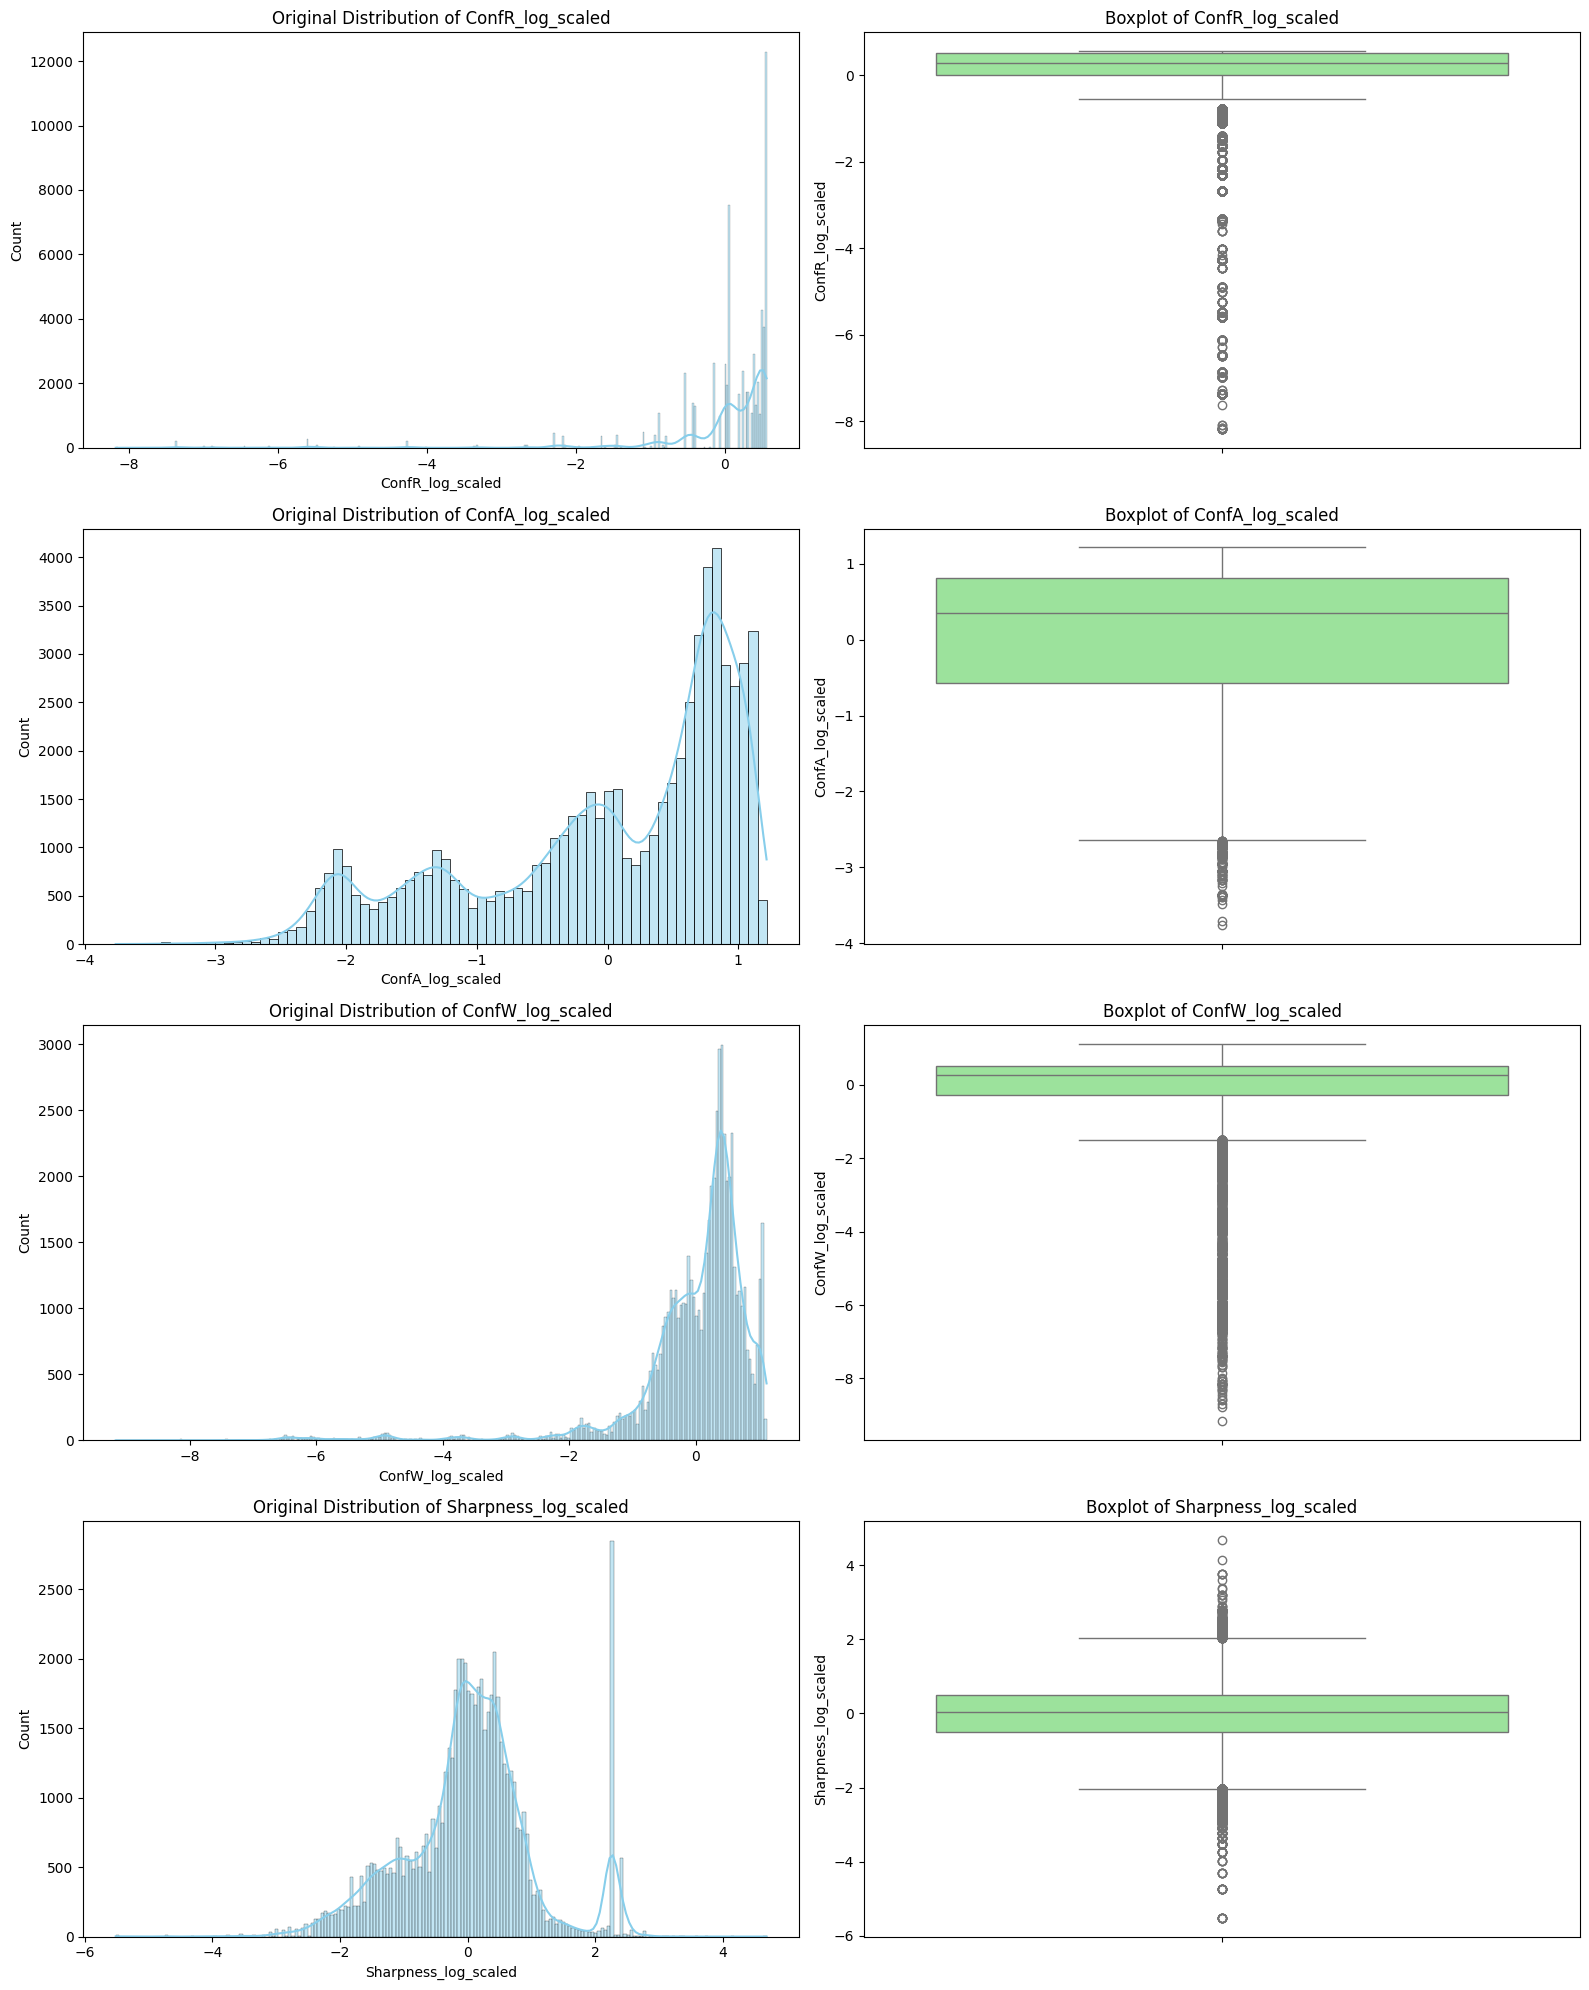

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de columnas numéricas de interés
numeric_columns = ['ConfR_log_scaled', 'ConfA_log_scaled','ConfW_log_scaled','Sharpness_log_scaled']

# Crear los subgráficos para visualizar las distribuciones
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(16, len(numeric_columns)*5))

# Iterar sobre las columnas para graficar
for i, column in enumerate(numeric_columns):
    # Obtener los datos originales
    original_data = df_transformed_final[column]  # Asegúrate de usar el DataFrame original, 'df'

    # Graficar la distribución original (histograma y boxplot)
    sns.histplot(original_data, kde=True, ax=axes[i, 0], color='skyblue')  # Histograma + KDE
    axes[i, 0].set_title(f"Original Distribution of {column}")

    sns.boxplot(data=original_data, ax=axes[i, 1], color='lightgreen')  # Boxplot
    axes[i, 1].set_title(f"Boxplot of {column}")

# Ajustar el layout de los gráficos para que no se solapen
plt.tight_layout()
plt.show()

# APLICACIÓN DE PCA

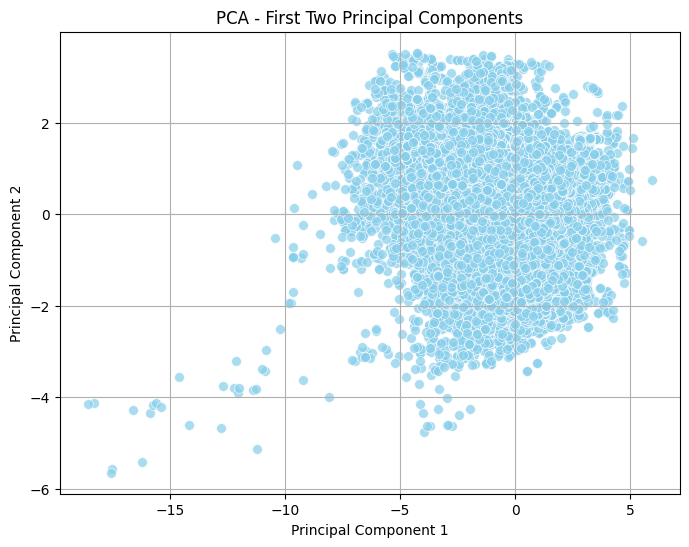

Explained variance by PCA components: [0.36473979 0.21275051 0.15249612]


In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Seleccionar solo las variables numéricas
numeric_columns = ['CompletedFields_log_scaled', 'ConfR_log_scaled', 'ConfA_log_scaled',
                   'ConfW_log_scaled', 'Sharpness_log_scaled', 'Contrast_log_scaled',
                   'Clarity_log_scaled', 'Resolution_log_scaled']

df_numeric = df_transformed_final[numeric_columns]

# 2. Escalar las variables numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# 3. Aplicar PCA
pca = PCA(n_components=3)  # Reducir a 2 componentes principales para visualización
df_pca = pca.fit_transform(df_scaled)

# 4. Graficar los resultados de PCA
plt.figure(figsize=(8,6))

# Visualización de los dos primeros componentes principales
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 2], color='skyblue', s=50, alpha=0.7)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# 5. Explicar la varianza explicada por los componentes
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")

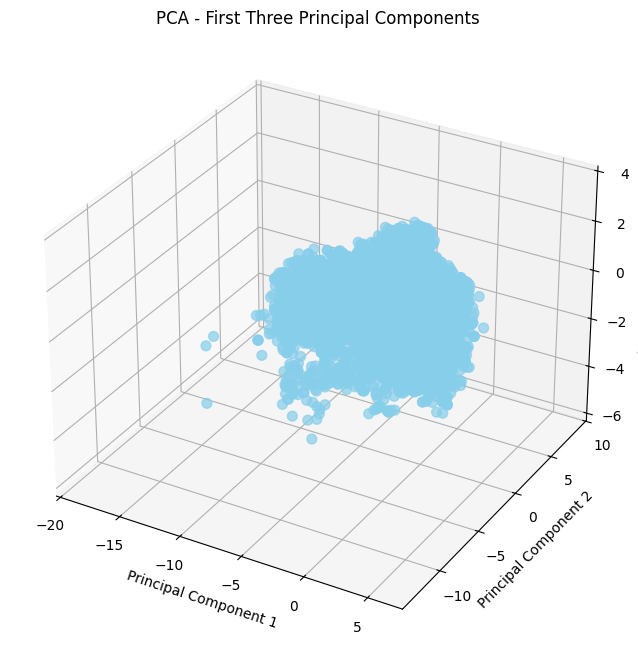

Explained variance by PCA components: [0.36473979 0.21275051 0.15249612 0.13038527]
Cumulative explained variance: [0.36473979 0.5774903  0.72998642 0.86037169]


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 1. Seleccionar solo las variables numéricas
numeric_columns = ['CompletedFields_log_scaled', 'ConfR_log_scaled', 'ConfA_log_scaled',
                   'ConfW_log_scaled', 'Sharpness_log_scaled', 'Contrast_log_scaled',
                   'Clarity_log_scaled', 'Resolution_log_scaled']

df_numeric = df_transformed_final[numeric_columns]

# 2. Escalar las variables numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# 3. Aplicar PCA
pca = PCA(n_components=4)  # Reducir a 4 componentes principales para visualización
df_pca = pca.fit_transform(df_scaled)

# 4. Graficar los resultados de PCA en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Visualización de los primeros tres componentes principales en 3D
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], color='skyblue', s=50, alpha=0.7)

ax.set_title('PCA - First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

# 5. Explicar la varianza explicada por los componentes
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")

# 6. Cálculo de la varianza acumulada
cumulative_variance = explained_variance.cumsum()
print(f"Cumulative explained variance: {cumulative_variance}")

In [26]:
# Asegurarse de que df_pca tenga nombres apropiados para las columnas
df_pca = pd.DataFrame(df_pca, columns=[f'PCA_Component_{i+1}' for i in range(4)])

# Seleccionar las columnas originales que no se incluyeron en PCA (por ejemplo, variables categóricas y demás)
df_remaining_columns = df_transformed_final.drop(columns=numeric_columns)

# Concatenar las columnas de PCA con las columnas restantes
df_final = pd.concat([df_remaining_columns, df_pca], axis=1)

# Verificar el DataFrame final
print(df_final.head())

   Model_comprobante_domicilio  Model_estado_cuenta  Model_ine  \
0                          1.0                  0.0        0.0   
1                          0.0                  0.0        0.0   
2                          0.0                  0.0        0.0   
3                          0.0                  0.0        1.0   
4                          0.0                  1.0        0.0   

   Model_recibo_nomina  DocType_APP  DocType_ATM  DocType_CABLE  DocType_CFE  \
0                  0.0          0.0          0.0            0.0          1.0   
1                  1.0          0.0          0.0            0.0          0.0   
2                  1.0          0.0          0.0            0.0          0.0   
3                  0.0          0.0          0.0            0.0          0.0   
4                  0.0          0.0          0.0            0.0          0.0   

   DocType_CLIB  DocType_CONST  ...  DocType_ISSSTE  DocType_PASS  \
0           0.0            0.0  ...             0.0  

In [27]:
df_final.head(3)

,Model_comprobante_domicilio,Model_estado_cuenta,Model_ine,Model_recibo_nomina,DocType_APP,DocType_ATM,DocType_CABLE,DocType_CFE,DocType_CLIB,DocType_CONST,...,DocType_ISSSTE,DocType_PASS,DocType_PEMEX,DocType_SEP,DocType_SUC,DocType_TEL,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.274437,0.953652,-0.940196,0.200065
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.812460,0.080168,0.431822,1.249105
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.826960,1.056716,-0.510437,1.150514


In [32]:
df_final.columns

Index(['Model_comprobante_domicilio', 'Model_estado_cuenta', 'Model_ine',
       'Model_recibo_nomina', 'DocType_APP', 'DocType_ATM', 'DocType_CABLE',
       'DocType_CFE', 'DocType_CLIB', 'DocType_CONST', 'DocType_EC',
       'DocType_GAS', 'DocType_IMSS', 'DocType_IMSS3', 'DocType_INE',
       'DocType_ISSSTE', 'DocType_PASS', 'DocType_PEMEX', 'DocType_SEP',
       'DocType_SUC', 'DocType_TEL', 'PCA_Component_1', 'PCA_Component_2',
       'PCA_Component_3', 'PCA_Component_4'],
      dtype='object')

In [37]:

# Ver la información general del DataFrame


print(df_transformed_final.info())

print(df_final.info())






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62960 entries, 0 to 62959
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CompletedFields_log_scaled   62960 non-null  float64
 1   ConfR_log_scaled             62960 non-null  float64
 2   ConfA_log_scaled             62960 non-null  float64
 3   ConfW_log_scaled             62960 non-null  float64
 4   Sharpness_log_scaled         62960 non-null  float64
 5   Contrast_log_scaled          62960 non-null  float64
 6   Clarity_log_scaled           62960 non-null  float64
 7   Resolution_log_scaled        62960 non-null  float64
 8   Model_comprobante_domicilio  62960 non-null  float64
 9   Model_estado_cuenta          62960 non-null  float64
 10  Model_ine                    62960 non-null  float64
 11  Model_recibo_nomina          62960 non-null  float64
 12  DocType_APP                  62960 non-null  float64
 13  DocType_ATM     